### Lyrics Matching

In [31]:
import numpy as np
import re
import matplotlib.pyplot as plt
from bnlp.corpus import _stopwords
import ipywidgets as widgets
import os
from IPython.display import clear_output
import zipfile
import sys
import json
import scipy
from bnlp import BengaliCorpus as corpus

In [82]:
filepath = './SongDB.json'

# To Plot the Vertical Bar Chart of Lyricist as well as Rhyme Scheme
n_top_rhymes = 6
n_top_singers = 6

# No of Author for whose entropy will be ploted in the Horizontal Bar Graph
n_author = 25

# Num of Rhymes to Plot
num_rhymes = 20

In [33]:
punctuations = corpus.punctuations
stopwords = _stopwords.bengali_stopwords
_vowels = corpus.vowels
with open(filepath) as f:
    data = json.load(f)

In [35]:
def clean(text):
	text = re.sub('[%s]' % re.escape(punctuations), '', text)
	# text = re.sub('\n', '', text)
	text = re.sub('\w*\d\w*', '', text)
	text = re.sub('\xa0', '', text)
	return text

In [36]:
def form_rhyme_dict(lyrics, rhyme_dict = dict()):
    x = lyrics.split('\n\n\n\n')
    for i in x:
        if len(i) == 0:
            continue
        rhyme = []
        last_chars = ''
        latest_rhyme_char_ASCII = 65
        y = i.split('\n\n')
        j = 0
        for _line in y:
            if len(_line) == 0 or _line == ' ':
                continue
            dep_vowels_flag = 0
            if _line[-1] in _vowels:
                new_last_char = _line[-2] + _line[-1]
                dep_vowels_flag = 1
            else:
                new_last_char = _line[-1]
            tmp = last_chars.find(new_last_char)
            last_chars = last_chars + new_last_char
            if tmp != (-1):
                rhyme.append(rhyme[tmp])
            else:
                rhyme.append(chr(latest_rhyme_char_ASCII))
                latest_rhyme_char_ASCII = latest_rhyme_char_ASCII + 1
            if dep_vowels_flag:
                rhyme.append(0)
        rhyme = [i for i in rhyme if i != 0]
        rhyme = ''.join(i for i in rhyme)
        if rhyme == '':
            continue
        tmp = (rhyme + rhyme).find(rhyme, 1, -1)
        if tmp != (-1):
            rhyme = rhyme[:tmp]
        if rhyme in rhyme_dict:
            rhyme_dict[rhyme] = rhyme_dict[rhyme] + 1
        else:
            rhyme_dict[rhyme] = 1
    return rhyme_dict

In [37]:
dict_list = dict()
for singer in list(data.keys()):
	singer_dict = dict()
	for song in data[singer]:
		lyrics = song['Lyrics']
		if len(lyrics) != 0:
			cleaned_lyrics = clean(lyrics)
			print(song)
			print(singer)
			singer_dict = form_rhyme_dict(cleaned_lyrics, singer_dict)
	dict_list[singer] = singer_dict


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [39]:
# Initialize an empty dictionary to store key sums
key_sums = {}

# Iterate through each dictionary
for sub_dict in dict_list.values():
    # Iterate through each key-value pair in the sub-dictionary
    for key, value in sub_dict.items():
        # Update the sum of the key in key_sums dictionary
        key_sums[key] = key_sums.get(key, 0) + value

_sum = []
for key, sum_value in key_sums.items():
    _sum.append(sum_value)


In [46]:
# Forming a dict of singer name and its corresponding number of songs
lyrics_count = dict()
for singer in data:
    lyrics_count[singer] = len(data[singer])
sorted_lyricist_count = dict(sorted(lyrics_count.items(), key = lambda key_val: key_val[1] , reverse = True))

In [48]:
sorted_unique_key_sums = dict(sorted(key_sums.items(), key = lambda key_val: key_val[1], reverse = True))

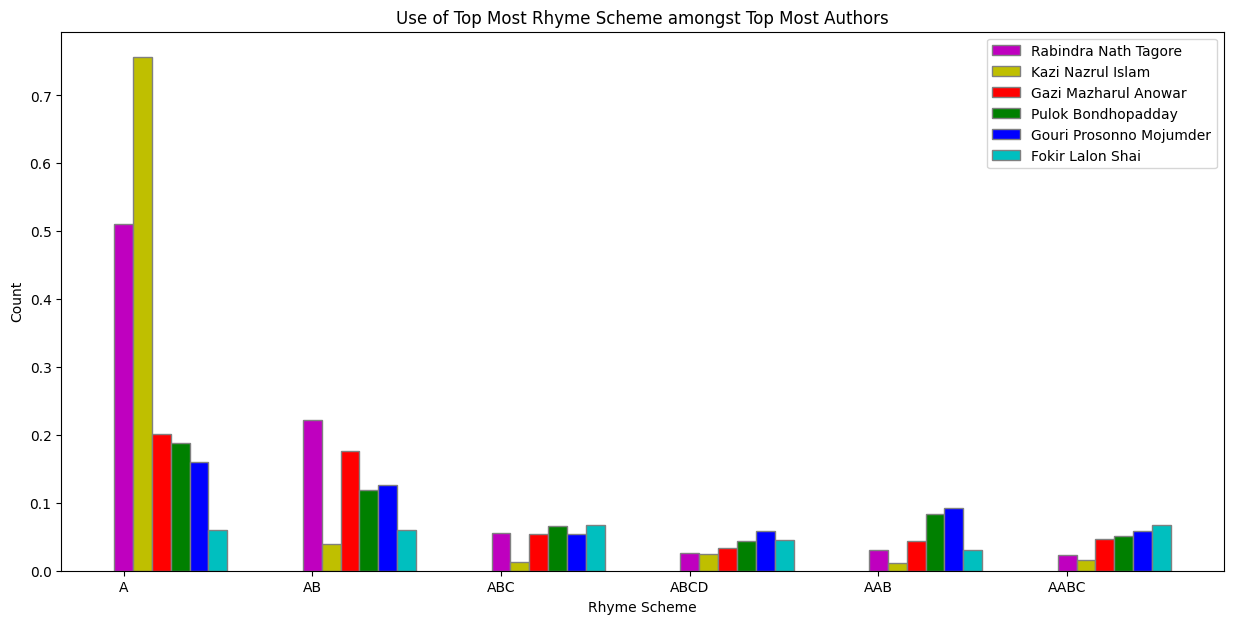

In [52]:
fig = plt.figure(figsize = (15, 7))
color_list = ['r', 'g', 'b', 'c', 'm', 'y']
bar_width = 0.10
x = np.arange(n_top_rhymes)
for i in range(0, n_top_singers):
    singer_name = list(sorted_lyricist_count.items())[i][0]
    singer_dict = dict_list[singer_name]
    total_lyrics = sum(list(singer_dict.values()))
    values = []
    for j in list(sorted_unique_key_sums.keys())[0:n_top_rhymes]:
        values.append(singer_dict[j] / total_lyrics)
    x = [y + bar_width for y in x]
    plt.bar(x , values, color = color_list[i-2], width = bar_width, label = singer_name, edgecolor ='grey')
plt.xlabel('Rhyme Scheme')
plt.ylabel('Count')
plt.xticks([r + (bar_width) for r in range(n_top_rhymes)], 
        list(sorted_unique_key_sums.keys())[:n_top_rhymes])
plt.title('Use of Top Most Rhyme Scheme amongst Top Most Authors')
plt.legend()
plt.show()
        


As we have very skewed distributed of songs across, we have normalized the counts of rhymes across each author. Here we can see that the rhymes 'A' is most used. We can see that the rhyming scheme of Rabindranath and Kazi Nazrul Islam is consistent. However, the bar plot shows that the Folk Songs (Fokir Lalon Shah) follows different types of rhyming schemes.

In [78]:
def calc_entropy(dict_list, sorted_lyricist_count, n_author):
    entropy_dict = dict()
    for singer in list(sorted_lyricist_count.keys())[0:n_author]:
        entropy_dict[singer] = scipy.stats.entropy(list(dict_list[singer].values()))
    return entropy_dict

In [79]:
def cal_entropy_and_plot(dict_list, sorted_lyricist_count, n_author):

    entropy_dict = calc_entropy(dict_list, sorted_lyricist_count, n_author)
    sorted_entropy_dict = dict(sorted(entropy_dict.items(), key = lambda key_val: key_val[1], reverse = True))

    # Plot a Horizontal Bar Plot
    y = list(sorted_entropy_dict.keys())[0:n_author]
    x = list(sorted_entropy_dict.values())[0:n_author]
    plt.barh(y, x)
    plt.xlabel('Entropy')
    plt.ylabel('Lyricist')
    plt.title('Comparing Entropy of lyricist')
    plt.show()
    return None

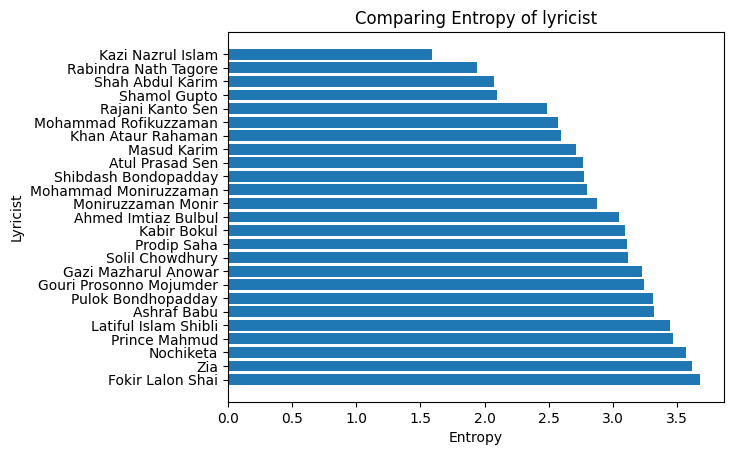

In [80]:
cal_entropy_and_plot(dict_list, sorted_lyricist_count, n_author)

In [83]:
# Plot Histogram of Lyrics by Rabindranath Tagore
def plot_histogram(singer_name, num_rhymes = 20):
    singer_dict = dict_list[singer_name]
    sorted_data = sorted(singer_dict.items(), key = lambda key_val: key_val[1], reverse= True)[0:num_rhymes]
    y = [i[1] for i in sorted_data]
    x = [i[0] for i in sorted_data]
    plt.barh(x, y)
    plt.xlabel('Count')
    plt.ylabel('Rhyme Schemes')
    plt.title('Rhyme Scheme Distribution of {}'.format(singer_name))
    plt.show()

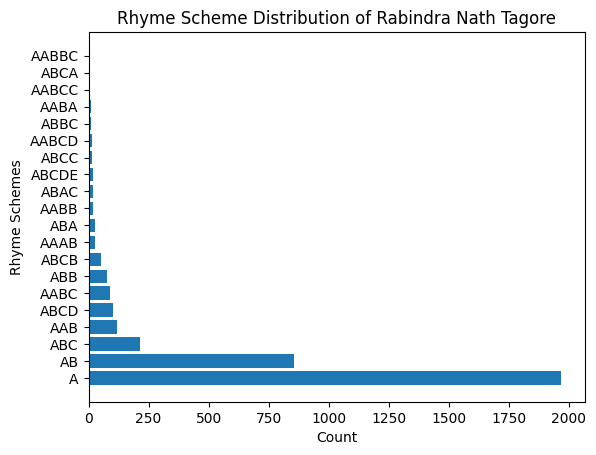

In [84]:
plot_histogram('Rabindra Nath Tagore', num_rhymes)

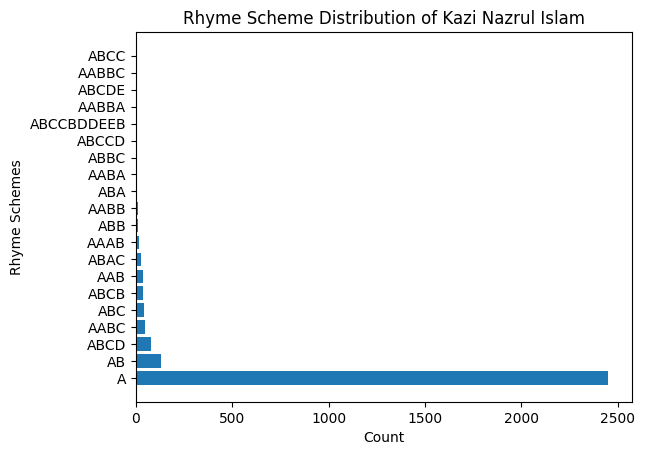

In [85]:
plot_histogram('Kazi Nazrul Islam', num_rhymes)

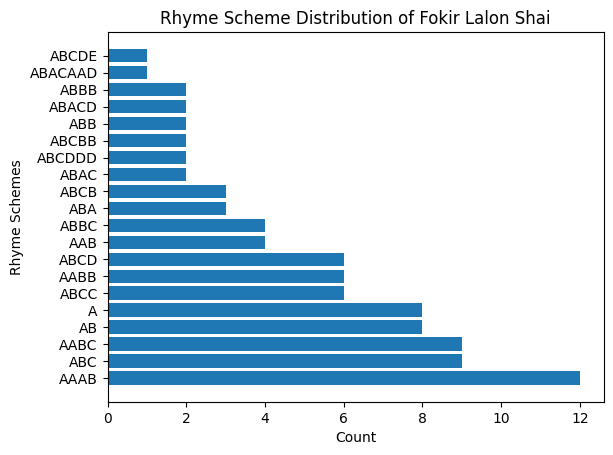

In [86]:
plot_histogram('Fokir Lalon Shai', num_rhymesm)

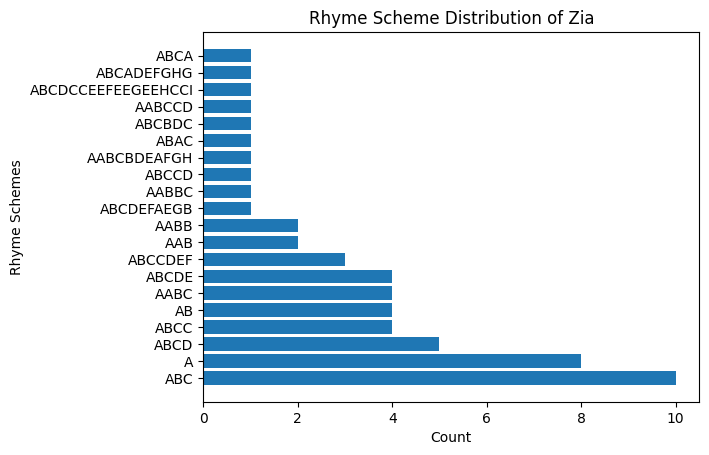

In [87]:
plot_histogram('Zia', num_rhymes)

### Rough Code

In [102]:
x

[('A', 1979),
 ('AB', 859),
 ('ABC', 213),
 ('AAB', 119),
 ('ABCD', 100),
 ('AABC', 88),
 ('ABB', 75),
 ('ABCB', 51),
 ('AAAB', 27),
 ('ABA', 27),
 ('AABB', 19),
 ('ABAC', 19),
 ('ABCDE', 18),
 ('ABCC', 16),
 ('AABCD', 15),
 ('ABBC', 12),
 ('AABA', 10),
 ('AABCC', 7),
 ('ABCA', 6),
 ('ABCBDEFB', 5),
 ('ABACD', 5),
 ('AABBC', 5),
 ('ABBB', 4),
 ('ABCDB', 4),
 ('ABCCDE', 4),
 ('ABCBDDEB', 4),
 ('ABCDD', 3),
 ('ABCCD', 3),
 ('AABCDE', 3),
 ('ABCDBEEFDB', 2)]

In [64]:
a = [1,2,3]
a.extend([2,4])
a

[1, 2, 3, 2, 4]

In [62]:
list(sorted_entropy_dict.values())[0:4]

[3.6792507310648115, 3.6141810395723892, 3.569072034885066, 3.4687832838129133]

In [70]:
sorted_entropy_dict['Rabindra Nath Tagore']

1.9338742823163235

In [71]:
sorted_entropy_dict['Kazi Nazrul Islam']

1.586477932412504

In [86]:
tmp = list(sorted_entropy_dict.values())[0:4]
tmp.append(sorted_entropy_dict['Rabindra Nath Tagore'])
print(tmp)
tmp.append(sorted_entropy_dict['Kazi Nazrul Islam'])
print(tmp)
entropy_val = tmp
print(entropy_val)
# entropy_val = tmp.extend([sorted_entropy_dict['Rabindra Nath Tagore'], sorted_entropy_dict['Kazi Nazrul Islam']])

[3.6792507310648115, 3.6141810395723892, 3.569072034885066, 3.4687832838129133, 1.9338742823163235]
[3.6792507310648115, 3.6141810395723892, 3.569072034885066, 3.4687832838129133, 1.9338742823163235, 1.586477932412504]
[3.6792507310648115, 3.6141810395723892, 3.569072034885066, 3.4687832838129133, 1.9338742823163235, 1.586477932412504]


In [87]:
entropy_val

[3.6792507310648115,
 3.6141810395723892,
 3.569072034885066,
 3.4687832838129133,
 1.9338742823163235,
 1.586477932412504]

In [88]:
total_entropy

58.58427246251695

In [89]:
entropy_val

[3.6792507310648115,
 3.6141810395723892,
 3.569072034885066,
 3.4687832838129133,
 1.9338742823163235,
 1.586477932412504]

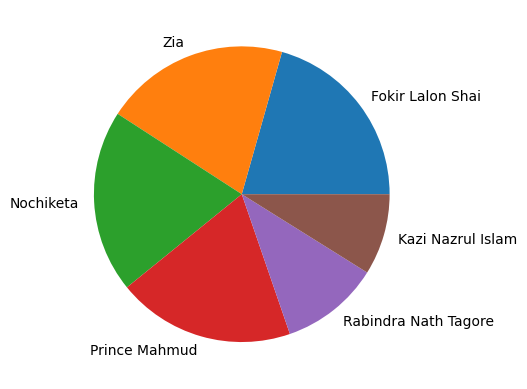

In [90]:
total_entropy = sum(list(sorted_entropy_dict.values()))
other_entropy = total_entropy - sum(entropy_val)
# entropy_val.append(other_entropy)
tmp = list(sorted_entropy_dict.keys())[0:4]
tmp.extend(['Rabindra Nath Tagore', 'Kazi Nazrul Islam'])
entropy_label =  tmp
plt.pie(entropy_val, labels = entropy_label)
plt.show() 

[3.6792507310648115, 3.6141810395723892, 3.569072034885066, 3.4687832838129133, 1.9338742823163235]
[3.6792507310648115, 3.6141810395723892, 3.569072034885066, 3.4687832838129133, 1.9338742823163235, 1.586477932412504]
[3.6792507310648115, 3.6141810395723892, 3.569072034885066, 3.4687832838129133, 1.9338742823163235, 1.586477932412504]


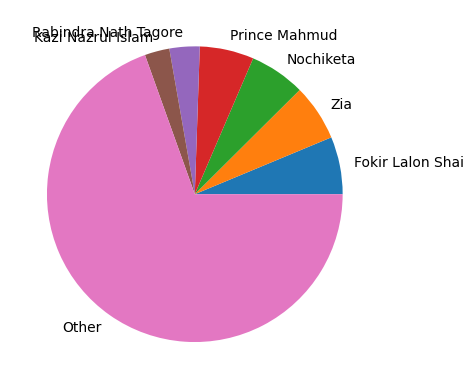

In [94]:
tmp = list(sorted_entropy_dict.values())[0:4]
tmp.append(sorted_entropy_dict['Rabindra Nath Tagore'])
print(tmp)
tmp.append(sorted_entropy_dict['Kazi Nazrul Islam'])
print(tmp)
entropy_val = tmp
print(entropy_val)
# tmp.extend([sorted_entropy_dict['Rabindra Nath Tagore'], sorted_entropy_dict['Kazi Nazrul Islam']])
entropy_val = tmp
total_entropy = sum(list(sorted_entropy_dict.values()))
other_entropy = total_entropy - sum(entropy_val)
entropy_val.append(other_entropy)
tmp = list(sorted_entropy_dict.keys())[0:4]
tmp.extend(['Rabindra Nath Tagore', 'Kazi Nazrul Islam', 'Other'])
entropy_label =  tmp
plt.pie(entropy_val, labels = entropy_label)
plt.show() 


In [350]:
for i in list(sorted_entropy_dict.keys()):
    print(i, '    ', sorted_entropy_dict[i], '     ', sorted_lyricist_count[i])

Fokir Lalon Shai      3.6792507310648115       50
Zia      3.6141810395723892       21
Nochiketa      3.569072034885066       17
Prince Mahmud      3.4687832838129133       20
Latiful Islam Shibli      3.4446801598253676       30
Ashraf Babu      3.3208517673480564       18
Gouri Prosonno Mojumder      3.2400376653789613       62
Gazi Mazharul Anowar      3.228487342962636       85
Solil Chowdhury      3.1210761837245564       20
Prodip Saha      3.106487820339716       16
Ahmed Imtiaz Bulbul      3.050529853857653       15
Humayun Ahmed      2.961402719817057       15
Moniruzzaman Monir      2.9095118502530912       21
Mohammad Moniruzzaman      2.8016448400953053       19
Shibdash Bondopadday      2.7775991054201       24
Khan Ataur Rahaman      2.599015438478199       18
Shamol Gupto      2.0995602277853807       20
Shah Abdul Karim      2.0717481831668505       17
Rabindra Nath Tagore      1.9338742823163235       857
Kazi Nazrul Islam      1.586477932412504       620


### Modification to find out the pattern 'A'


In [319]:
def form_rhyme_dict(lyrics, rhyme_dict = dict()):
    # rhyme_dict = dict()
    # x = x[0]
    x = lyrics.split('\n\n\n\n')
    for i in x:
        if len(i) == 0:
            continue
        rhyme = []
        last_chars = ''
        latest_rhyme_char_ASCII = 65
        # print(i)
        y = i.split('\n\n')
        j = 0
        # n_dep_vowels = 0
        for _line in y:
            if len(_line) == 0 or _line == ' ':
                continue
            # print(_line)
            dep_vowels_flag = 0
            if _line[-1] in _vowels:
                # print(_line)
                new_last_char = _line[-2] + _line[-1]
                dep_vowels_flag = 1
                # rhyme.append(0)
            else:
                new_last_char = _line[-1]
            tmp = last_chars.find(new_last_char)
            last_chars = last_chars + new_last_char
            if tmp != (-1):
                # print(tmp, rhyme, new_last_char, last_chars)
                rhyme.append(rhyme[tmp])
            else:
                rhyme.append(chr(latest_rhyme_char_ASCII))
                latest_rhyme_char_ASCII = latest_rhyme_char_ASCII + 1
            if dep_vowels_flag:
                rhyme.append(0)
        rhyme = [i for i in rhyme if i != 0]
        rhyme = ''.join(i for i in rhyme)
        if rhyme == '':
            continue
        #Finding the duplicate in the rhyme
        tmp = (rhyme + rhyme).find(rhyme, 1, -1)
        if tmp != (-1):
            rhyme = rhyme[:tmp]
        if rhyme == 'A':
            print('-------------------------------------------------')
            print(y)
        if rhyme in rhyme_dict:
            rhyme_dict[rhyme] = rhyme_dict[rhyme] + 1
        else:
            rhyme_dict[rhyme] = 1
    return rhyme_dict

In [320]:
path = './Dataset/Data'
dict_list = dict()
singer_name_list = []
for singer in os.listdir(path):
	singer_dict = dict()
	for song in os.listdir(os.path.join(path, singer)):
		tmp = os.path.join(path, singer, song)
		try:
			lyrics = docx2txt.process(tmp)
		except zipfile.BadZipFile:
			pass
		if len(lyrics) != 0:
			cleaned_lyrics = clean(lyrics)
			print(song)
			print(singer)
			singer_dict = form_rhyme_dict(cleaned_lyrics, singer_dict)
	dict_list[singer] = singer_dict


song1_প্রেমের খেলা কে বুঝিতে পারে.docx
Sopon Chakraborti
song3_খেলবো হোলি রঙ দেব না.docx
Sopon Chakraborti
-------------------------------------------------
['ও ও ওলালে লালে অাবীর লালে', 'আকাশ হল লাল']
-------------------------------------------------
['ও ওবৃন্দাবনে হোলী খেলে', 'নন্দের দুলাল']
song2_নাই নাই এ আধার থেকে.docx
Sopon Chakraborti
song9_আমার ভাঙ্গা ঘরে ভাঙ্গা চালা ভাঙ্গা বেড়ার ফাঁকে.docx
Humayun Ahmed
song8_ও কারিগর, দয়ার সাগর, ওগো দয়াময়.docx
Humayun Ahmed
-------------------------------------------------
['ও কারিগর দয়ার সাগর ওগো দয়াময়', 'চান্নি পসর রাইতে যেন আমার মরণ হয়']
-------------------------------------------------
['ও কারিগর দয়ার সাগর ওগো দয়াময়', 'চান্নি পসর রাইতে যেন আমার মরণ হয়']
song15_.docx
Humayun Ahmed
-------------------------------------------------
['ও কারিগর দয়ার সাগর ওগো দয়াময়', 'চান্নি পসর রাইতে যেন আমার মরণ হয়']
-------------------------------------------------
['ও কারিগর দয়ার সাগর ওগো দয়াময়', 'চান্নি পসর রাইতে যেন আমার মরণ হয়']
song2_সোহাগপুর গ্রামে একট

### Rough Code

In [21]:
!git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git

Cloning into 'indic_nlp_resources'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 139 (delta 2), reused 2 (delta 0), pack-reused 126
Receiving objects: 100% (139/139), 149.77 MiB | 7.96 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [22]:
!git clone https://github.com/anoopkunchukuttan/indic_nlp_library.git

Cloning into 'indic_nlp_library'...
remote: Enumerating objects: 1404, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 1404 (delta 139), reused 152 (delta 124), pack-reused 1219
Receiving objects: 100% (1404/1404), 9.57 MiB | 10.62 MiB/s, done.
Resolving deltas: 100% (749/749), done.


In [27]:
!ls

Bengali_word_cloud.png	Dataset		     Kalpurush.ttf
bn_wordcloud.py		indic_nlp_library    lyrics_pattern_reco.ipynb
circle.png		indic_nlp_resources


In [28]:
# The path to the local git repo for Indic NLP library
INDIC_NLP_LIB_HOME=r"./indic_nlp_library"

# The path to the local git repo for Indic NLP Resources
INDIC_NLP_RESOURCES=r"./indic_nlp_resources"

In [29]:
import sys
sys.path.append(r'{}'.format(INDIC_NLP_LIB_HOME))

In [30]:
from indicnlp import common
common.set_resources_path(INDIC_NLP_RESOURCES)

In [31]:
from indicnlp import loader
loader.load()

In [2]:
import numpy as np
import pandas as pd
import cv2
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# from bnlp.corpus import stopwords, punctuations
from bnlp.corpus import _stopwords
from bnlp.corpus import corpus
import docx2txt
import ipywidgets as widgets
import os
from IPython.display import clear_output
import zipfile
import sys

In [3]:
punctuations = corpus.BengaliCorpus.punctuations
stopwords = _stopwords.bengali_stopwords

In [4]:
def clean(text):
	text = re.sub('[%s]' % re.escape(punctuations), '', text)
	# text = re.sub('\n', '', text)
	text = re.sub('\w*\d\w*', '', text)
	text = re.sub('\xa0', '', text)
	return text

In [197]:
def form_rhyme_dict(lyrics, rhyme_dict = dict()):
    # rhyme_dict = dict()
    # x = x[0]
    x = lyrics.split('\n\n\n\n')
    for i in x:
        if len(i) == 0:
            continue
        rhyme = []
        last_chars = ''
        latest_rhyme_char_ASCII = 65
        # print(i)
        y = i.split('\n\n')
        j = 0
        # n_dep_vowels = 0
        for _line in y:
            if len(_line) == 0 or _line == ' ':
                continue
            # print(_line)
            dep_vowels_flag = 0
            if _line[-1] in _vowels:
                # print(_line)
                new_last_char = _line[-2] + _line[-1]
                dep_vowels_flag = 1
                # rhyme.append(0)
            else:
                new_last_char = _line[-1]
            tmp = last_chars.find(new_last_char)
            last_chars = last_chars + new_last_char
            if tmp != (-1):

                # print(tmp, rhyme, new_last_char, last_chars)
                rhyme.append(rhyme[tmp])
            else:
                rhyme.append(chr(latest_rhyme_char_ASCII))
                latest_rhyme_char_ASCII = latest_rhyme_char_ASCII + 1
            if dep_vowels_flag:
                rhyme.append(0)
        rhyme = [i for i in rhyme if i != 0]
        rhyme = ''.join(i for i in rhyme)
        if rhyme in rhyme_dict:
            rhyme_dict[rhyme] = rhyme_dict[rhyme] + 1
        else:
            rhyme_dict[rhyme] = 1
    return rhyme_dict

In [198]:
path = '.'
path = os.path.join(path, 'Dataset')
path = os.path.join(path, 'Data')
dict_list = dict()
singer_name_list = []
for singer in os.listdir(path):
	singer_dict = dict()
	for song in os.listdir(os.path.join(path, singer)):
		tmp = os.path.join(path, singer, song)
		try:
			lyrics = docx2txt.process(tmp)
		except zipfile.BadZipFile:
			pass
		if len(lyrics) != 0:
			cleaned_lyrics = clean(lyrics)
			print(song)
			print(singer)
			singer_dict = form_rhyme_dict(cleaned_lyrics, singer_dict)
	dict_list[singer] = singer_dict


song1_প্রেমের খেলা কে বুঝিতে পারে.docx
Sopon Chakraborti
song3_খেলবো হোলি রঙ দেব না.docx
Sopon Chakraborti
song2_নাই নাই এ আধার থেকে.docx
Sopon Chakraborti
song9_আমার ভাঙ্গা ঘরে ভাঙ্গা চালা ভাঙ্গা বেড়ার ফাঁকে.docx
Humayun Ahmed
song8_ও কারিগর, দয়ার সাগর, ওগো দয়াময়.docx
Humayun Ahmed
song15_.docx
Humayun Ahmed
song2_সোহাগপুর গ্রামে একটা মায়া দীঘি ছিল.docx
Humayun Ahmed
song13_.docx
Humayun Ahmed
song3_বরষার প্রথম দিনে.docx
Humayun Ahmed
song7_একটা ছিল সোনার কন্যা.docx
Humayun Ahmed
song14_.docx
Humayun Ahmed
song10_যদি মন কাঁদে তুমি চলে এসো.docx
Humayun Ahmed
song4_বাদলা দিনে মনে পড়ে ছেলেবেলার গান.docx
Humayun Ahmed
song11_আসমান ভাইঙ্গা জোছনা পড়ে.docx
Humayun Ahmed
song5_আমি আজ ভেজাবো চোখ.docx
Humayun Ahmed
song6_ও আমার উড়াল পঙ্খী রে.docx
Humayun Ahmed
song1_মাথায় পরেছি সাদা ক্যাপ.docx
Humayun Ahmed
song1_দুই পৃথিবী.docx
Snehasis Ghosh
song2_কোন অভিযোগ.docx
LRB
song1_গতকাল রাতে.docx
LRB
song3_জন্মহীন নক্ষত্র.docx
LRB
song1_জীবনে যারে তুমি দাওনি মালা.docx
Pronob Roy
song2_মধুর আমার মা

In [199]:
dict_list

{'Sopon Chakraborti': {'AB': 10,
  'ABCD': 4,
  'ABA': 1,
  'AAB': 1,
  'ABABCDBE': 1,
  'ABCDBE': 1,
  'AA': 2,
  'ABAC': 1,
  'ABCBDEE': 1,
  'ABCBDE': 1},
 'Humayun Ahmed': {'AABC': 2,
  'AABB': 5,
  'AA': 12,
  'ABCC': 3,
  'AABBB': 6,
  'ABCCC': 1,
  'ABACAD': 1,
  'AABAA': 1,
  'ABBB': 1,
  'ABBCC': 2,
  'AABACCC': 2,
  'AABA': 3,
  'ABACDEDD': 2,
  'ABC': 3,
  'AAB': 1,
  'ABCDEF': 2,
  'ABCCDE': 1,
  'ABCBDEBFB': 2,
  'AABCDCC': 1,
  'ABCD': 3,
  'ABBCDE': 1,
  'AABCDA': 1,
  'ABABCDEFC': 1,
  'AAAABCBD': 1,
  'AABCD': 1,
  'AABCDBDEFGHAA': 1,
  'AABCDD': 1},
 'Snehasis Ghosh': {'AA': 4, 'A': 3},
 'LRB': {'ABCAADEEAE': 1,
  'ABCDDCD': 1,
  'ABCDDED': 1,
  'ABCD': 4,
  'ABC': 1,
  'AA': 1,
  'A': 1,
  'ABAC': 3,
  'ABACD': 1,
  'AAB': 1},
 'Pronob Roy': {'AABA': 2,
  'ABCBDDEF': 1,
  'ABBC': 3,
  'ABCCBDE': 1,
  'ABAC': 1,
  'AABC': 1},
 'Sayyed Shamsul Haque': {'ABCA': 1,
  'AA': 24,
  'ABCC': 3,
  'AABA': 2,
  'ABBB': 2,
  'AABAC': 2,
  'AAB': 8,
  'AAAA': 1,
  'AB': 11,
  'AA

In [200]:
# Initialize an empty dictionary to store key sums
key_sums = {}

# Iterate through each dictionary
for sub_dict in dict_list.values():
    # Iterate through each key-value pair in the sub-dictionary
    for key, value in sub_dict.items():
        # Update the sum of the key in key_sums dictionary
        key_sums[key] = key_sums.get(key, 0) + value

# Print the unique keys and their associated sums
print("Unique Keys and Sums:")
for key, sum_value in key_sums.items():
    
    print(key, ":", sum_value)


Unique Keys and Sums:
AB : 1502
ABCD : 458
ABA : 112
AAB : 389
ABABCDBE : 1
ABCDBE : 5
AA : 1057
ABAC : 91
ABCBDEE : 9
ABCBDE : 21
AABC : 343
AABB : 116
ABCC : 108
AABBB : 20
ABCCC : 10
ABACAD : 3
AABAA : 8
ABBB : 44
ABBCC : 10
AABACCC : 3
AABA : 55
ABACDEDD : 2
ABC : 546
ABCDEF : 22
ABCCDE : 14
ABCBDEBFB : 2
AABCDCC : 1
ABBCDE : 5
AABCDA : 1
ABABCDEFC : 1
AAAABCBD : 1
AABCD : 46
AABCDBDEFGHAA : 1
AABCDD : 9
A : 4025
ABCAADEEAE : 1
ABCDDCD : 1
ABCDDED : 1
ABACD : 18
ABCBDDEF : 1
ABBC : 80
ABCCBDE : 1
ABCA : 29
AABAC : 17
AAAA : 59
ABAA : 14
ABCDDE : 3
ABCBA : 4
ABCDE : 79
AABCBCD : 1
ABB : 216
ABCDCB : 1
ABBCA : 6
ABCB : 320
ABBCBD : 2
ABABBC : 3
AAA : 123
ABCDD : 26
ABACA : 1
ABABCCD : 1
ABCDEEF : 5
AABBC : 33
ABCDB : 15
AABCAA : 2
AABCDEBF : 1
ABCDEFGHIJ : 2
AABACADEFG : 1
AABCDEFF : 3
AABBCC : 11
ABCADE : 2
AAABCD : 5
ABCBDEDBFG : 1
ABCDEEEEEBFG : 1
ABCABDEFC : 1
ABCDEC : 6
ABBCDBEFDC : 1
ABBCBDEAEFFB : 1
ABCBDAEFGH : 1
ABBCD : 20
AABCC : 25
ABCBDEFEGFHH : 1
ABCBDEFF : 2
AABCDEE : 3

In [202]:
len(key_sums)

970

In [190]:
p = './Dataset/Data/Kazi Nazrul Islam/song224_ঘুমাও, ঘুমাও, দেখিতে এসেছি.docx'
l = docx2txt.process(p)
l_c = clean(l)
print(l_c)


ঘুমাওঘুমাওদেখিতে এসেছি ভাঙাতে আসিনি ঘুম



 



কেউ জেগে কাঁদেকারো চোখে নামে নিদালির মৌসুম॥



দেখিতে এলাম হয়ে কুতুহলী



 



চাঁপাফুল দিয়ে তৈরী পুতুলী



 



দেখিশয্যায় স্তূপ হয়ে আছে জোছনার কুমকুম



 



আমি নই ঐ কলঙ্কী চাঁদ নয়নে হেনেছে চুম্ 



 



রাগ করিও না অনুরাগ হতে রাগ আরো ভালো লাগে



 



তৃষ্ণাতুরের কেউ জল চায় কেউ বা শিরাজি মাগে



 



     মনে কর আমি লোলুপ বাতাস



 



     চোরজোছনা ফুলের সুবাস



 



ভয় নাই আমি চলে যাই ডাকি নিশীথিনী নিঝুম


In [195]:
def form_rhyme_dict(lyrics, rhyme_dict = dict()):
    # rhyme_dict = dict()
    # x = x[0]
    x = lyrics.split('\n\n\n\n')
    for i in x:
        if len(i) == 0:
            continue
        rhyme = []
        last_chars = ''
        latest_rhyme_char_ASCII = 65
        # print(i)
        y = i.split('\n\n')
        j = 0
        # n_dep_vowels = 0
        for _line in y:
            if len(_line) == 0:
                continue
            if _line == ' ':
                print(1)
            print(6, len(_line))
            dep_vowels_flag = 0
            if _line[-1] in _vowels:
                # print(_line)
                new_last_char = _line[-2] + _line[-1]
                dep_vowels_flag = 1
                # rhyme.append(0)
            else:
                new_last_char = _line[-1]
            tmp = last_chars.find(new_last_char)
            last_chars = last_chars + new_last_char
            if tmp != (-1):

                # print(tmp, rhyme, new_last_char, last_chars)
                rhyme.append(rhyme[tmp])
            else:
                rhyme.append(chr(latest_rhyme_char_ASCII))
                latest_rhyme_char_ASCII = latest_rhyme_char_ASCII + 1
            if dep_vowels_flag:
                rhyme.append(0)
        rhyme = [i for i in rhyme if i != 0]
        rhyme = ''.join(i for i in rhyme)
        if rhyme in rhyme_dict:
            rhyme_dict[rhyme] = rhyme_dict[rhyme] + 1
        else:
            rhyme_dict[rhyme] = 1
    return rhyme_dict

In [196]:
a  = form_rhyme_dict(l_c)

6 39
1
6 1


IndexError: string index out of range

In [176]:
l_c = l_c.split('\n\n\n\n')
print(l_c)

['মনে হয় স্বর্গে আছি\n\nশেকড় ছাড়া গাছ বাঁচে\n\nজল ছাড়া মাছ বাঁচে না\n\nনেশা নিয়ে আমি বাঁচি', 'উর্বশী আর অপ্সরা সব\n\nআমায় ঘিরে কোমর নাচায়\n\nমনে আমার রস জুগিয়ে\n\nওরা যে আমার বাঁচায়', 'এতো ফুলের মধ্যে এখন\n\nমধু খেতে কোনটা বাছি কোনটা বাছি', 'মাথা থেকে ভাবনা তাড়ায়\n\nএকটু আধটু নেশা করে\n\nমাথা ব্যাথায় কাজ কি আমার\n\nআধ মনই এক মুকুট পড়ে', '\n\nকিছুই যে কাল থাকবে তো\n\nআজ রাজা কাল তাকে কেউ\n\nরাজা বলে ডাকবে না তো\n\nসুখের বাধন কাঁটতে আছে\n\nনিয়তিই হাত কাচি\n\nকাচিরে ভাই কাচি']


In [178]:
for x in l_c:
    # print(x)
    print(len(x))
    for j in x.split('\n\n'):
        print(len(j))
    print('---------------------------------------------------')

82
18
19
20
19
---------------------------------------------------
81
19
20
18
18
---------------------------------------------------
51
19
30
---------------------------------------------------
88
21
18
24
19
---------------------------------------------------
124
0
21
20
20
21
15
15
---------------------------------------------------


In [162]:
len(l)

0

In [161]:
print(l)

In [5]:
singer = "Abdul_Alim"
path = "."
path = os.path.join(path, 'Dataset')
path = os.path.join(path, 'Data')
path = os.path.join(path, singer)

print(path)

./Dataset/Data/Abdul_Alim


In [6]:
!pwd

/home/user/Documents/a2/Pro/WordCloud


In [252]:
path_file = "./Dataset/Data/Abdul_Alim/song1_আর_কতকাল_ভাসবো_আমি.docx"
text = docx2txt.process(path_file)
text = clean(text)


In [253]:
print(text)

আর কতকাল ভাসবো আমি

দুখের সারী গাইয়া

জনম গেল ঘাটে ঘাটে আমার

জনম গেল ঘাটে ঘাটে

ভাঙা তরী বাইয়া রে আমার

ভাঙ্গা তরী বাইয়া



পরের বোঝা বইয়া বইয়া

নৌকার গলুই গেছে খইয়ারে

আমার নিজের বোঝা কে বলিবে রে

রাখবো কোথায় যাওয়ারে আমি

রাখবো কোথায় যাওয়া



এই জীবনে দেখলাম নদীর

কতই ভাঙা গড়া

আমার দেহতরী ভাঙলো শুধু

না জাগিলো চড়া



আমার ভবে কেউ কি আছে

দুখ কবো তাহার কাছে রে

আমি রইলাম শুধু দয়াল আল্লাহ রে

আমি রইলাম শুধু দয়াল আল্লাহ

তোমার পানে চাইয়া রে

আমি তোমার পানে চাইয়া


In [254]:
a = form_rhyme_dict(text)

In [255]:
a

{'ABCDCB': 1, 'ABBCA': 1, 'ABCB': 1, 'ABBCBD': 1}

In [8]:
path_file

'./Dataset/Data/Abdul_Alim/song1_আর_কতকাল_ভাসবো_আমি.docx'

In [82]:
text = docx2txt.process(path_file)

In [10]:
text

'আর কতকাল ভাসবো আমি\n\nদুঃখের সারী গাইয়া\n\nজনম গেল ঘাটে ঘাটে আমার\n\nজনম গেল ঘাটে ঘাটে\n\nভাঙা তরী বাইয়া রে আমার\n\nভাঙ্গা তরী বাইয়া।।\n\n\n\nপরের বোঝা বইয়া বইয়া\n\nনৌকার গলুই গেছে খইয়ারে।\n\nআমার নিজের বোঝা কে বলিবে রে।\n\nরাখবো কোথায় যাওয়ারে আমি\n\nরাখবো কোথায় যাওয়া।।\n\n\n\nএই জীবনে দেখলাম নদীর\n\nকতই ভাঙা গড়া\n\nআমার দেহতরী ভাঙলো শুধু\n\nনা জাগিলো চড়া\n\n\n\nআমার ভবে কেউ কি আছে\n\nদুঃখ কবো তাহার কাছে রে\n\nআমি রইলাম শুধু দয়াল আল্লাহ রে\n\nআমি রইলাম শুধু দয়াল আল্লাহ\n\nতোমার পানে চাইয়া রে\n\nআমি তোমার পানে চাইয়া।।'

In [11]:
'abc'.find('e')

-1

In [136]:
a =  dict()
a['abs'] = 1
def f (d):
    d['dv'] = 2
    return None
f(a)
print(a)

{'abs': 1, 'dv': 2}


In [12]:
'b' in 'abc'

True

In [241]:
a = 'abab'
r = ''
t = (a + a).find(a, 1, -1)
if t != -1:
    print(t)
    r = a[:t]
print(r)

2
ab


In [224]:
# a = 'dabcabc'
# r = ''

# # Concatenate a with itself
# concatenated_a = a + a

# # Initialize a variable to store the index of the first occurrence of 'abab'
# t = -1

# # Loop through each index of the concatenated string, excluding the last occurrence
# for i in range(1, len(concatenated_a) - len(a)):
#     # Check if the substring at the current index matches 'abab'

#     if concatenated_a[i:i+len(a)] == a:
#         print(i)
#         t = i
#         break  # Break out of the loop once 'abab' is found
#     else:
#         print('Stupid', i)

# if t != -1:
#     print(t)
#     r = a[:t]

# print(r)


Stupid 1
Stupid 2
Stupid 3
Stupid 4
Stupid 5
Stupid 6



In [242]:
r = ''

# Concatenate a with itself
concatenated_a = a + a

# Initialize a variable to store the index of the first occurrence of 'abab'
t = -1

# Loop through each index of the concatenated string, excluding the last occurrence
for i in range(1, len(concatenated_a) - len(a)):
    # Check if the substring at the current index matches 'abab'

    if concatenated_a[i:i+len(a)] == a:
        print(i)
        t = i
        break  # Break out of the loop once 'abab' is found
    else:
        print('Stupid', i)

if t != -1:
    print(t)
    r = a[:t]

print(r)


Stupid 1
2
2
ab


In [243]:


# Python3 code to demonstrate working of 
# Check if string repeats itself 
# Using list slicing + find() 
 
# initializing string 
test_str = "GeeksforGeeksGeeksforGeeksGeeksforGeeks"
 
# printing original string 
print("The original string is : " + test_str) 
 
# using list slicing + find() 
# Check if string repeats itself 
res = None
new_str = test_str + test_str
print(new_str)
temp =new_str.find(test_str, 1, -1) 
print(temp)
if temp != -1: 
    res = test_str[:temp] 
 
# printing result 
print(res)
# print("The root substring of string : " + res) 

The original string is : GeeksforGeeksGeeksforGeeksGeeksforGeeks
GeeksforGeeksGeeksforGeeksGeeksforGeeksGeeksforGeeksGeeksforGeeksGeeksforGeeks
13
GeeksforGeeks


In [244]:
print(text)

আর কতকাল ভাসবো আমি

দুখের সারী গাইয়া

জনম গেল ঘাটে ঘাটে আমার

জনম গেল ঘাটে ঘাটে

ভাঙা তরী বাইয়া রে আমার

ভাঙ্গা তরী বাইয়া



পরের বোঝা বইয়া বইয়া

নৌকার গলুই গেছে খইয়ারে

আমার নিজের বোঝা কে বলিবে রে

রাখবো কোথায় যাওয়ারে আমি

রাখবো কোথায় যাওয়া



এই জীবনে দেখলাম নদীর

কতই ভাঙা গড়া

আমার দেহতরী ভাঙলো শুধু

না জাগিলো চড়া



আমার ভবে কেউ কি আছে

দুখ কবো তাহার কাছে রে

আমি রইলাম শুধু দয়াল আল্লাহ রে

আমি রইলাম শুধু দয়াল আল্লাহ

তোমার পানে চাইয়া রে

আমি তোমার পানে চাইয়া


In [245]:
text = clean(text)

In [246]:
a = form_rhyme_dict(text)

In [247]:
print(text)

আর কতকাল ভাসবো আমি

দুখের সারী গাইয়া

জনম গেল ঘাটে ঘাটে আমার

জনম গেল ঘাটে ঘাটে

ভাঙা তরী বাইয়া রে আমার

ভাঙ্গা তরী বাইয়া



পরের বোঝা বইয়া বইয়া

নৌকার গলুই গেছে খইয়ারে

আমার নিজের বোঝা কে বলিবে রে

রাখবো কোথায় যাওয়ারে আমি

রাখবো কোথায় যাওয়া



এই জীবনে দেখলাম নদীর

কতই ভাঙা গড়া

আমার দেহতরী ভাঙলো শুধু

না জাগিলো চড়া



আমার ভবে কেউ কি আছে

দুখ কবো তাহার কাছে রে

আমি রইলাম শুধু দয়াল আল্লাহ রে

আমি রইলাম শুধু দয়াল আল্লাহ

তোমার পানে চাইয়া রে

আমি তোমার পানে চাইয়া


In [248]:
a

{'ABCDCE': 1, 'ABBCB': 1, 'ABCB': 4, 'ABBCBD': 4, 'ABCDCB': 3, 'ABBCA': 3}

In [226]:
cleaned_text = clean(text)

In [89]:
type(cleaned_text)

str

In [227]:
x = cleaned_text.split('\n\n\n\n')

In [228]:
y = x[1]
y

'পরের বোঝা বইয়া বইয়া\n\nনৌকার গলুই গেছে খইয়ারে\n\nআমার নিজের বোঝা কে বলিবে রে\n\nরাখবো কোথায় যাওয়ারে আমি\n\nরাখবো কোথায় যাওয়া'

In [132]:
rhyme_dict

{'ABCDCB': 1}

In [128]:
rhyme = [i for i in rhyme if i != 0]
rhyme

['A', 'B', 'C', 'D', 'C', 'B']

In [129]:
rhyme = ''.join(i for i in rhyme)

In [130]:
rhyme

'ABCDCB'

In [ ]:
ABCDCB


In [119]:
# Original list
my_list = [1, 2, 3, 3, 4, 5]

# Number to remove
number_to_remove = 3

# Check if the number is in the list
if number_to_remove in my_list:
    # Remove the number from the list
    my_list.remove(number_to_remove)
    print("Number removed successfully.")
else:
    print("Number not found in the list.")

# Print the updated list
print("Updated List:", my_list)


Number removed successfully.
Updated List: [1, 2, 3, 4, 5]


In [134]:
def form_rhyme_dict(lyrics, rhyme_dict = dict()):
    # rhyme_dict = dict()
    # x = x[0]
    for i in lyrics:
        rhyme = []
        last_chars = ''
        latest_rhyme_char_ASCII = 65
        y = i.split('\n\n')
        j = 0
        # n_dep_vowels = 0
        for _line in y:
            # print(_line)
            dep_vowels_flag = 0
            if _line[-1] in _vowels:
                # print(_line)
                new_last_char = _line[-2] + _line[-1]
                dep_vowels_flag = 1
                # rhyme.append(0)
            else:
                new_last_char = _line[-1]
            tmp = last_chars.find(new_last_char)
            last_chars = last_chars + new_last_char
            if tmp != (-1):

                # print(tmp, rhyme, new_last_char, last_chars)
                rhyme.append(rhyme[tmp])
            else:
                rhyme.append(chr(latest_rhyme_char_ASCII))
                latest_rhyme_char_ASCII = latest_rhyme_char_ASCII + 1
            if dep_vowels_flag:
                rhyme.append(0)
        rhyme = [i for i in rhyme if i != 0]
        rhyme = ''.join(i for i in rhyme)
        if rhyme in rhyme_dict:
            rhyme_dict[rhyme] = rhyme_dict[rhyme] + 1
        else:
            rhyme_dict[rhyme] = 1


In [135]:
rhyme_dict

{'ABCDCB': 1, 'ABBCA': 1, 'ABCB': 1, 'ABBCBD': 1}

In [ ]:
y = x[0]

In [87]:
from bnlp import BengaliCorpus as corpus

# print(corpus.stopwords)
# print(corpus.punctuations)
# print(corpus.letters)
# print(corpus.digits)
# print(corpus.vowels)
_vowels = corpus.vowels


In [14]:
import indicnlp

In [32]:
from indicnlp.syllable import  syllabifier


In [20]:
from indicnlp import common
common.set_resources_path(INDIC_NLP_RESOURCES)

NameError: name 'INDIC_NLP_RESOURCES' is not defined

In [19]:
from indicnlp import loader
loader.load()

IndicNlpException: 'INDIC_RESOURCES_PATH not set'

In [111]:
w

'গাইয়া'

In [43]:
from indicnlp.morph import unsupervised_morph 
from indicnlp import common

analyzer=unsupervised_morph.UnsupervisedMorphAnalyzer('bn')

In [45]:
indic_string='দুঃখের সারী গাইয়া'

analyzes_tokens=analyzer.morph_analyze_document(indic_string.split(' '))

for w in analyzes_tokens: 
    print(w)

দুঃখ
ের
সার
ী
গাই
য়া


In [ ]:
c = 'গাইয়া'

c.find()

In [17]:
syllabifier.orthographic_syllabify_improved(w,lang)

NameError: name 'w' is not defined

In [61]:
!pip install indicngram


In [62]:
from indicngram import correction

# Example Bengali text with errors
text_with_errors = "আমি বাংলা লাংয়েজ শিখছি"

# Correct the Bengali text
corrected_text = correction.correct_text(text_with_errors)

# Print the corrected text
print("Corrected Text:", corrected_text)


ModuleNotFoundError: No module named 'core'

In [205]:
w = 'বাইয়া'
lang='bn'

a = ' '
# Break into syllables
a = a.join(syllabifier.orthographic_syllabify_improved(w,lang))
a

'বা ই য় া'

In [66]:
w = 'বাইয়া'
a = 'ী'
b = w[-2]
c = b + a
print(a, b)
print(c)
ab = w + c
ab[-1]

ী য়
য়ী


'ী'

In [70]:
len(c)

2

In [71]:
c[0]

'য়'

In [65]:
w[3]

'য়'

In [68]:
c

'য়ী'

In [69]:
w

'বাইয়া'

In [67]:
w.find(c)

-1

In [42]:
print(a)

বা ই য় া


In [39]:
w = 'जगदीशचंद्र'
lang = 'hi'
a = syllabifier.orthographic_syllabify_improved(w,lang)
print(a)

['ज', 'ग', 'दी', 'श', 'च', 'ंद्र']


In [48]:
a = 'abcdefff'
b = a[0:].find('f')

In [51]:
a[0:2]

'ab'

In [49]:
b

5

In [73]:
a = []
a.append('abc')

In [74]:
a.append(c)
c

'য়ী'

In [79]:
a == 'abc'

False

In [75]:
a

['abc', 'য়ী']

In [77]:
a[1][0]

'য়'

In [78]:
a.find('abc')

AttributeError: 'list' object has no attribute 'find'

In [54]:
a = ['a', 'b', 'c']
b = str(a)
b

"['a', 'b', 'c']"

In [50]:
chr(65)

'A'

In [81]:
b = 'A' + 1

TypeError: can only concatenate str (not "int") to str

In [80]:
a = chr(65) + 1
a

TypeError: can only concatenate str (not "int") to str

In [91]:
if None:
    print('a')

In [102]:
rhyme_dict = dict()
# x = x[0]
for i in x:
    rhyme = ''
    last_chars = ''
    latest_rhyme_char_ASCII = 65
    y = i.split('\n\n')
    j = 0
    for _line in y:
        print(_line)
        if _line[-1] in _vowels:
            new_last_char = _line[-2] + _line[-1]
        else:
            new_last_char = _line[-1]
        tmp = last_chars.find(new_last_char)
        last_chars = last_chars + new_last_char
        if tmp != (-1):

            print(tmp, rhyme, new_last_char, last_chars)
            rhyme = rhyme + rhyme[tmp-1]
        else:
            rhyme = rhyme + chr(latest_rhyme_char_ASCII)
            latest_rhyme_char_ASCII = latest_rhyme_char_ASCII + 1
    print('RHYME', rhyme)
    if rhyme in rhyme_dict:
        rhyme_dict[rhyme] = rhyme_dict[rhyme] + 1
    else:
        rhyme_dict[rhyme] = 1


আ
RHYME A
র
RHYME A
 


IndexError: string index out of range

In [101]:
rhyme_dict

{'ABCDDB': 1, 'ABBCC': 1, 'ABCA': 1, 'ABBCBD': 1}

In [96]:
print(cleaned_text)

আর কতকাল ভাসবো আমি

দুখের সারী গাইয়া

জনম গেল ঘাটে ঘাটে আমার

জনম গেল ঘাটে ঘাটে

ভাঙা তরী বাইয়া রে আমার

ভাঙ্গা তরী বাইয়া



পরের বোঝা বইয়া বইয়া

নৌকার গলুই গেছে খইয়ারে

আমার নিজের বোঝা কে বলিবে রে

রাখবো কোথায় যাওয়ারে আমি

রাখবো কোথায় যাওয়া



এই জীবনে দেখলাম নদীর

কতই ভাঙা গড়া

আমার দেহতরী ভাঙলো শুধু

না জাগিলো চড়া



আমার ভবে কেউ কি আছে

দুখ কবো তাহার কাছে রে

আমি রইলাম শুধু দয়াল আল্লাহ রে

আমি রইলাম শুধু দয়াল আল্লাহ

তোমার পানে চাইয়া রে

আমি তোমার পানে চাইয়া


In [44]:
x

['আর কতকাল ভাসবো আমি\n\nদুখের সারী গাইয়া\n\nজনম গেল ঘাটে ঘাটে আমার\n\nজনম গেল ঘাটে ঘাটে\n\nভাঙা তরী বাইয়া রে আমার\n\nভাঙ্গা তরী বাইয়া',
 'পরের বোঝা বইয়া বইয়া\n\nনৌকার গলুই গেছে খইয়ারে\n\nআমার নিজের বোঝা কে বলিবে রে\n\nরাখবো কোথায় যাওয়ারে আমি\n\nরাখবো কোথায় যাওয়া',
 'এই জীবনে দেখলাম নদীর\n\nকতই ভাঙা গড়া\n\nআমার দেহতরী ভাঙলো শুধু\n\nনা জাগিলো চড়া',
 'আমার ভবে কেউ কি আছে\n\nদুখ কবো তাহার কাছে রে\n\nআমি রইলাম শুধু দয়াল আল্লাহ রে\n\nআমি রইলাম শুধু দয়াল আল্লাহ\n\nতোমার পানে চাইয়া রে\n\nআমি তোমার পানে চাইয়া']

In [45]:
y = x[0].split('\n\n')

In [50]:
y

['আর কতকাল ভাসবো আমি',
 'দুখের সারী গাইয়া',
 'জনম গেল ঘাটে ঘাটে আমার',
 'জনম গেল ঘাটে ঘাটে',
 'ভাঙা তরী বাইয়া রে আমার',
 'ভাঙ্গা তরী বাইয়া']

In [57]:
from bnlp import CleanText

clean_text = CleanText(
   fix_unicode=True,
   unicode_norm=True,
   unicode_norm_form="NFKC",
   remove_url=False,
   remove_email=False,
   remove_emoji=False,
   remove_number=False,
   remove_digits=False,
   remove_punct=False,
   replace_with_url="<URL>",
   replace_with_email="<EMAIL>",
   replace_with_number="<NUMBER>",
   replace_with_digit="<DIGIT>",
   replace_with_punct = "<PUNC>"
)

In [52]:
from bnlp import CleanText

clean_text = CleanText(
   fix_unicode=True,
   unicode_norm=True,
   unicode_norm_form="NFKC",
   remove_url=False,
   remove_email=False,
   remove_emoji=False,
   remove_number=False,
   remove_digits=False,
   remove_punct=False,
   replace_with_url="<URL>",
   replace_with_email="<EMAIL>",
   replace_with_number="<NUMBER>",
   replace_with_digit="<DIGIT>",
   replace_with_punct = "<PUNC>"
)

input_text = "আমার সোনার বাংলা।"
clean_text = clean_text(input_text)
print(clean_text)

আমার সোনার বাংলা।


In [58]:
c = clean_text(text)

In [60]:
print(c)

আর কতকাল ভাসবো আমি

দুঃখের সারী গাইয়া

জনম গেল ঘাটে ঘাটে আমার

জনম গেল ঘাটে ঘাটে

ভাঙা তরী বাইয়া রে আমার

ভাঙ্গা তরী বাইয়া।।



পরের বোঝা বইয়া বইয়া

নৌকার গলুই গেছে খইয়ারে।

আমার নিজের বোঝা কে বলিবে রে।

রাখবো কোথায় যাওয়ারে আমি

রাখবো কোথায় যাওয়া।।



এই জীবনে দেখলাম নদীর

কতই ভাঙা গড়া

আমার দেহতরী ভাঙলো শুধু

না জাগিলো চড়া



আমার ভবে কেউ কি আছে

দুঃখ কবো তাহার কাছে রে

আমি রইলাম শুধু দয়াল আল্লাহ রে

আমি রইলাম শুধু দয়াল আল্লাহ

তোমার পানে চাইয়া রে

আমি তোমার পানে চাইয়া।।


In [61]:
x = c.split('\n\n\n\n')

In [62]:
x

['আর কতকাল ভাসবো আমি\n\nদুঃখের সারী গাইয়া\n\nজনম গেল ঘাটে ঘাটে আমার\n\nজনম গেল ঘাটে ঘাটে\n\nভাঙা তরী বাইয়া রে আমার\n\nভাঙ্গা তরী বাইয়া।।',
 'পরের বোঝা বইয়া বইয়া\n\nনৌকার গলুই গেছে খইয়ারে।\n\nআমার নিজের বোঝা কে বলিবে রে।\n\nরাখবো কোথায় যাওয়ারে আমি\n\nরাখবো কোথায় যাওয়া।।',
 'এই জীবনে দেখলাম নদীর\n\nকতই ভাঙা গড়া\n\nআমার দেহতরী ভাঙলো শুধু\n\nনা জাগিলো চড়া',
 'আমার ভবে কেউ কি আছে\n\nদুঃখ কবো তাহার কাছে রে\n\nআমি রইলাম শুধু দয়াল আল্লাহ রে\n\nআমি রইলাম শুধু দয়াল আল্লাহ\n\nতোমার পানে চাইয়া রে\n\nআমি তোমার পানে চাইয়া।।']

In [63]:
y = x[0].split('\n\n')

In [64]:
y 

['আর কতকাল ভাসবো আমি',
 'দুঃখের সারী গাইয়া',
 'জনম গেল ঘাটে ঘাটে আমার',
 'জনম গেল ঘাটে ঘাটে',
 'ভাঙা তরী বাইয়া রে আমার',
 'ভাঙ্গা তরী বাইয়া।।']

In [76]:
b = y[0][-2]
a = y[0][-1]
c = b + a
print(a, b)
print(c)

ি ম
মি


In [77]:
from bnlp import BengaliCorpus as corpus

print(corpus.stopwords)
print(corpus.punctuations)
print(corpus.letters)
print(corpus.digits)
print(corpus.vowels)


['অতএব', 'অথচ', 'অথবা', 'অনুযায়ী', 'অনেক', 'অনেকে', 'অনেকেই', 'অন্তত', 'অন্য', 'অবধি', 'অবশ্য', 'অর্থাত', 'আই', 'আগামী', 'আগে', 'আগেই', 'আছে', 'আজ', 'আদ্যভাগে', 'আপনার', 'আপনি', 'আবার', 'আমরা', 'আমাকে', 'আমাদের', 'আমার', 'আমি', 'আর', 'আরও', 'ই', 'ইত্যাদি', 'ইহা', 'উচিত', 'উত্তর', 'উনি', 'উপর', 'উপরে', 'এ', 'এঁদের', 'এঁরা', 'এই', 'একই', 'একটি', 'একবার', 'একে', 'এক্', 'এখন', 'এখনও', 'এখানে', 'এখানেই', 'এটা', 'এটাই', 'এটি', 'এত', 'এতটাই', 'এতে', 'এদের', 'এব', 'এবং', 'এবার', 'এমন', 'এমনকী', 'এমনি', 'এর', 'এরা', 'এল', 'এস', 'এসে', 'ঐ', 'ও', 'ওঁদের', 'ওঁর', 'ওঁরা', 'ওই', 'ওকে', 'ওখানে', 'ওদের', 'ওর', 'ওরা', 'কখনও', 'কত', 'কবে', 'কমনে', 'কয়েক', 'কয়েকটি', 'করছে', 'করছেন', 'করতে', 'করবে', 'করবেন', 'করলে', 'করলেন', 'করা', 'করাই', 'করায়', 'করার', 'করি', 'করিতে', 'করিয়া', 'করিয়ে', 'করে', 'করেই', 'করেছিলেন', 'করেছে', 'করেছেন', 'করেন', 'কাউকে', 'কাছ', 'কাছে', 'কাজ', 'কাজে', 'কারও', 'কারণ', 'কি', 'কিংবা', 'কিছু', 'কিছুই', 'কিন্তু', 'কী', 'কে', 'কেউ', 'কেউই', 'কেখা', 'কেন', 'কোটি', 'কোন', 'কোনও'

In [79]:
a = ord('A')
print(a)

65


In [80]:
chr(65)

'A'

In [68]:
print(a, b)

ি ম


In [70]:
c = a + b
print(c)

িম


In [69]:
print(c)

িম


In [65]:
print(y[0][-1])

ি


In [53]:
print(input_text)

আমার সোনার বাংলা।


In [74]:
a = y[0][-2]
b = y[0][-1]
print(a, b)
c = a + b
print(c)

ম ি
মি


In [75]:
c

'মি'

In [33]:
print(cleaned_text)

আর কতকাল ভাসবো আমি

দুখের সারী গাইয়া

জনম গেল ঘাটে ঘাটে আমার

জনম গেল ঘাটে ঘাটে

ভাঙা তরী বাইয়া রে আমার

ভাঙ্গা তরী বাইয়া



পরের বোঝা বইয়া বইয়া

নৌকার গলুই গেছে খইয়ারে

আমার নিজের বোঝা কে বলিবে রে

রাখবো কোথায় যাওয়ারে আমি

রাখবো কোথায় যাওয়া



এই জীবনে দেখলাম নদীর

কতই ভাঙা গড়া

আমার দেহতরী ভাঙলো শুধু

না জাগিলো চড়া



আমার ভবে কেউ কি আছে

দুখ কবো তাহার কাছে রে

আমি রইলাম শুধু দয়াল আল্লাহ রে

আমি রইলাম শুধু দয়াল আল্লাহ

তোমার পানে চাইয়া রে

আমি তোমার পানে চাইয়া


In [25]:
print(cleaned_text)

ালভাসবোআমিdocx


In [34]:
cleaned_text[0]

'আ'